## 混合ガウス分布で分布関数は近似できるか？

In [1]:
using LinearAlgebra, Plots

In [2]:
mutable struct gParams
    K::Int
    μ::Vector{Float32}
    Σ::Vector{Float32}
    ϕ::Vector{Float32}
end

function init_params(K::Int)
    μ = rand(Uniform(-1.0,1.0),K)
    Σ = ones(K)
    ϕ = [1.0/K for i in 1:K]
    return gParams(K, μ, Σ, ϕ)
end

init_params (generic function with 1 method)

In [3]:
using Distributions

In [4]:
function gmm0(w::Float32, p::gParams)
    μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([ϕ[i]*pdf(Normal(μ[i], Σ[i]), w) for i in 1:p.K])
    return y
end
function gmm1(w::Float32, p::gParams)
    #μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([p.ϕ[i]*pdf(Normal(p.μ[i], p.Σ[i]), w) for i in 1:p.K])
    return y
end

function logpws(ws::Vector{Float32}, true_ρ::Vector{Float32}, p::gParams)
    dw = ws[2]-ws[1]
    return dw*(true_ρ'*[log(gmm1(w, p)) for w in ws])
end

function D_kl(ws::Vector{Float32}, true_ρ::Vector{Float32}, p::gParams)
    f(x) = gmm1(x, p)
    K = length(ws)
    dw = ws[2]-ws[1]
    return sum([dw*true_ρ[i]*(log(true_ρ[i]+1f-8)-log(f(ws[i])+1f-8)) for i in 1:K])
end

function p_now(ws::Vector{Float32}, p::gParams)
    f(x) = gmm1(x, p)
    return Float32[f(w) for w in ws]
end

p_now (generic function with 1 method)

In [5]:
function E_step(ws::Vector{Float32}, p::gParams)
    q = zeros(Float32, size(ws)[1], p.K)
    for (i,w) in enumerate(ws)
        for k in 1:p.K
            q[i,k] = p.ϕ[k]*pdf(Normal(p.μ[k], p.Σ[k]), w)
        end
        q[i,:] = q[i,:]/(sum(q[i,:])+1f-8)
    end
    return q
end

function M_step!(ws::Vector{Float32}, true_ρ::Vector{Float32}, q::Matrix{Float32}, params::gParams)
    Nd = size(ws)[1]
    dw = ws[2] - ws[1]
    for k in 1:params.K
        qsum = true_ρ'*q[:,k]
        params.ϕ[k] = dw*qsum
        params.μ[k] = sum(true_ρ .* q[:,k] .* ws)/qsum
        #params.Σ[k] = sum(true_ρ .* q[:,k] .* (ws .- params.μ[k]) .* (ws .- params.μ[k]))/qsum
        params.Σ[k] = sqrt(sum([true_ρ[i] * q[i,k] * (ws[i] - params.μ[k]) * (ws[i] - params.μ[k]) for i in 1:Nd])/qsum)
        #params.Σ[k] = params.Σ[k]/qsum
    end
    params.ϕ = params.ϕ/sum(params.ϕ)
end

M_step! (generic function with 1 method)

In [6]:
using Flux

In [7]:
X = 5
@show μs = Float32.(rand(Uniform(-0.5f0,0.5f0),X))
@show σs = Float32.(rand(Uniform(0.01f0,0.2f0),X))
@show ρs = softmax(randn(Float32, X))


μs = Float32.(rand(Uniform(-0.5f0, 0.5f0), X)) = Float32[0.4499594, -0.15527368, -0.44294038, 0.481221, -0.32777196]
σs = Float32.(rand(Uniform(0.01f0, 0.2f0), X)) = Float32[0.0185654, 0.14638819, 0.19528465, 0.086143516, 0.059815474]
ρs = softmax(randn(Float32, X)) = Float32[0.15921596, 0.32914376, 0.075227104, 0.35505968, 0.08135349]


5-element Vector{Float32}:
 0.15921596
 0.32914376
 0.075227104
 0.35505968
 0.08135349

In [8]:
ws = [range(-1.0f0,1.0f0, length=501)...]
#gg(x, η) = (2η/((x-0.1)^2+η^2))/(2pi)
gg(x, η) = (2η/((x-0.2)^2+η^2) + 2η/((x+0.2)^2+η^2))/(4pi)
true_ρ = Float32[gg(w, 0.02f0) for w in ws]
#true_ρ = [gmm0(w, gParams(X, μs, σs, ρs)) for w in ws]

501-element Vector{Float32}:
 0.007180357
 0.0072452077
 0.0073109674
 0.0073776534
 0.007445283
 0.0075138756
 0.007583449
 0.007654024
 0.0077256183
 0.0077982536
 0.00787195
 0.007946729
 0.00802261
 ⋮
 0.007946729
 0.00787195
 0.0077982536
 0.0077256183
 0.007654024
 0.007583449
 0.0075138756
 0.007445283
 0.0073776534
 0.0073109674
 0.0072452077
 0.007180357

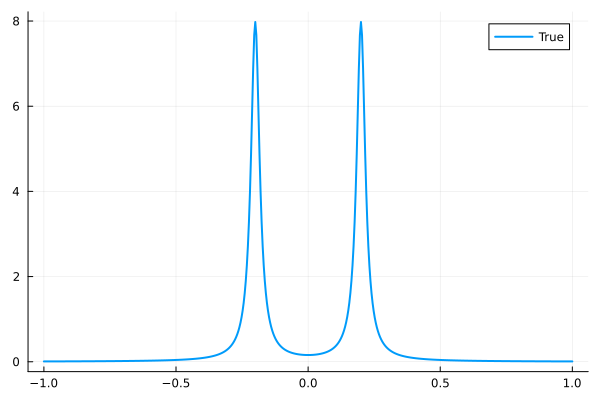

In [9]:
plot(ws, true_ρ, linewidth=2, label="True")

In [10]:
#plot(ws, true_ρ, linewidth=2, label="True")
function EM(dkl_max::Float32, X::Int)
    #X = 10
    itr_max = 2000
    th = 1e-6
    gp = init_params(X)
    old_logpx = logpws(ws, true_ρ, gp)

    for i in 1:itr_max
        qs = E_step(ws, gp)
        #println(qs)
        M_step!(ws, true_ρ, qs, gp)
        new_logpx = logpws(ws, true_ρ, gp)
        dkl = D_kl(ws, true_ρ, gp)
        if (abs(new_logpx - old_logpx) < th && dkl < dkl_max)
            #dkl = D_kl(ws, true_ρ, gp)
            println("itr: ", i, " logpx: ", new_logpx, " converged!")
            println("D_kl: ", dkl)
            break
        end
        old_logpx = new_logpx
    end
    return gp
end

EM (generic function with 1 method)

itr: 350 logpx: 0.8866014 converged!
D_kl: -0.011710919


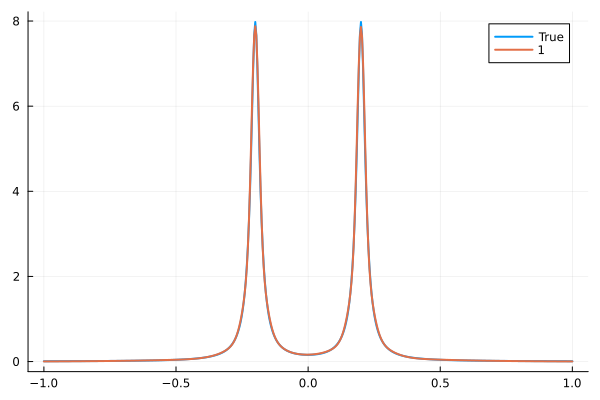

In [11]:
gp =  EM(0.01f0, 10)
p_test = p_now(ws, gp)
plot(ws, true_ρ, linewidth=2, label="True")
plot!(ws, p_test, linewidth=2, label="1")

itr: 533 logpx: 0.8844345 converged!
D_kl: -0.009543991


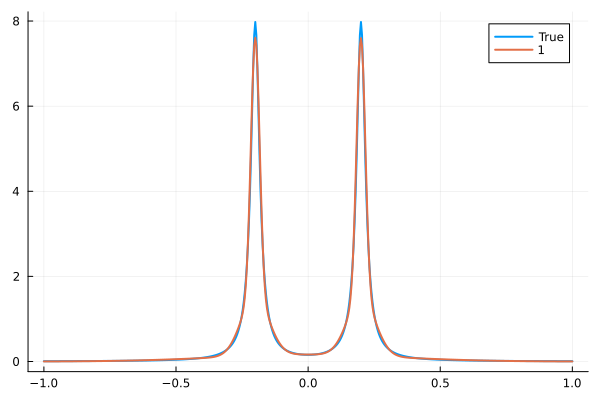

In [14]:
gp =  EM(0.001f0, 5)
p_test = p_now(ws, gp)
plot(ws, true_ρ, linewidth=2, label="True")
plot!(ws, p_test, linewidth=2, label="1")

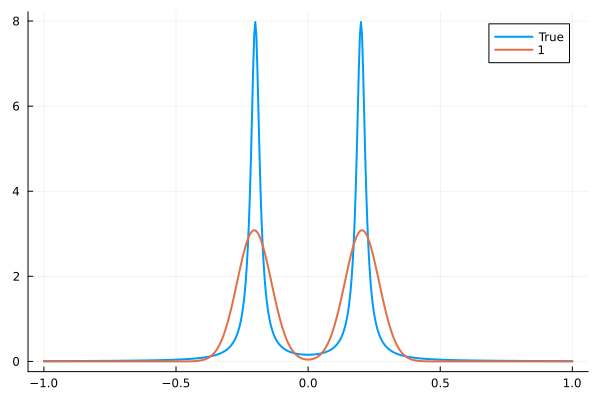

In [15]:
gp =  EM(0.1f0, 2)
p_test = p_now(ws, gp)
plot(ws, true_ρ, linewidth=2, label="True")
plot!(ws, p_test, linewidth=2, label="1")

## 近似した結果物理量とかは変わるのか？ (伝導度チェック)

In [18]:
struct H_params
    t::Float32
    μ::Float32
    β::Float32
    K_size::Int
    ws::Vector{Float32}
end

In [28]:
function Ham(k::Vector{Float32}, p::H_params)
    return -p.t * sum(cos.(k)) + p.μ
end

Ham (generic function with 1 method)

In [20]:
mutable struct Hamiltonian
    Hk::Float32
    Vx::Float32
    Vy::Float32
    #ws::Vector{Float32}
end

In [59]:
function HandV(k::Vector{Float32}, p::H_params)
    Hk = Ham(k, p)
    Vx = p.t * sin(k[1])
    Vy = p.t * sin(k[2])
    #ws = [range(-1.0f0,1.0f0, length=501)...]
    return Hamiltonian(Hk, Vx, Vy)
end

function ρwk(k::Vector{Float32}, w_e::Float32, η::Float32)
    return η/((w_e)^2+ η^2)/pi
end

function ρwk_vec(k::Vector{Float32}, ws::Vector{Float32}, e::Float32, η::Float32)
    return [ρwk(k, w-e, η) for w in ws]
end

function EM_fit(itr_max::Int, X::Int, ws::Vector{Float32}, ρ::Vector{Float32})
    th = 1e-6
    gp = init_params(X)
    old_logpx = logpws(ws, true_ρ, gp)

    for i in 1:itr_max
        qs = E_step(ws, gp)
        M_step!(ws, ρ, qs, gp)
        new_logpx = logpws(ws, ρ, gp)
        dkl = D_kl(ws, ρ, gp)
        if (abs(new_logpx - old_logpx) < th && dkl < 1f-3)
            break
        end
        old_logpx = new_logpx
    end

    dkl = D_kl(ws, ρ, gp)
    if(dkl > 0.1f0)
        println("D_KL: ", dkl)
    end
    p_app = p_now(ws, gp)

    return p_app
end

EM_fit (generic function with 1 method)

In [23]:
ph = H_params(0.2f0, 0.0f0, 100f0, 100, [range(-1.0f0,1.0f0, length=501)...])

H_params(0.2f0, 0.0f0, 100.0f0, 100, Float32[-1.0, -0.996, -0.992, -0.988, -0.984, -0.98, -0.976, -0.972, -0.968, -0.964  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0])

In [32]:
kxv = collect(Float32,-pi:2*pi/ph.K_size:pi)
kyv = collect(Float32,-pi:2*pi/ph.K_size:pi)
dk = 0.01f0
#Float32((kxv[2] - kxv[1])/2pi)

0.01f0

In [62]:
function fd(β::Float32, w::Float32)
    return Float32(1/(exp(β*w) + 1))
end
function dfd(β::Float32, w::Float32)
    return Float32(1/(exp(β*w) + 1)/(exp(-β*w) + 1))
end
function fds(β::Float32, ws::Vector{Float32})
    return [fd(β, w) for w in ws]
end
function dfds(β::Float32, ws::Vector{Float32})
    return [dfd(β, w) for w in ws]
end

dfds (generic function with 1 method)

In [65]:
function check_xx(μ::Float32, β::Float32)
    ph = H_params(0.2f0, μ, β, 100, [range(-1.0f0,1.0f0, length=501)...])
    σxx_true = 0.0f0
    σxx_gmm = 0.0f0
    dfdv = dfds(ph.β, ph.ws)
    #=
    kx = Float32(pi/2)
    ky = Float32(pi/2)
    Hs = HandV([kx, ky], ph)
    ρw = ρwk_vec([kx, ky], ws, Hs.Hk, 0.02f0)
    σxx_true = dk^2*Hs.Vx^2*sum(ρw.^2 .* fdv)
    ρ_gmm = EM_fit(3000, 5, ph.ws, ρw)
    σxx_gmm = dk^2*Hs.Vx^2*sum(ρ_gmm.^2 .* fdv)=#
    
    for kx in kxv
        for ky in kyv
            Hs = HandV([kx, ky], ph)
            ρw = ρwk_vec([kx, ky], ws, Hs.Hk, 0.02f0)
            σxx_true += dk^2*Hs.Vx^2*sum(ρw.^2 .* dfdv)
            ρ_gmm = EM_fit(2000, 10, ph.ws, ρw)
            σxx_gmm += dk^2*Hs.Vx^2*sum(ρ_gmm.^2 .* dfdv)
        end
    end
    dkl = ρw'*[log(ρw[i]+1f-8)-log(ρ_gmm[i]+1f-8) for i in 1:length(ρw)]
    dkl *= (ph.ws[2] - ph.ws[1])

    return σxx_true, σxx_gmm, dkl
end
#println("True: ", σxx_true)
#println("GMM: ", σxx_gmm)
#println("dkl: ", ρw'*[log(ρw[i]+1f-8)-log(ρ_gmm[i]+1f-8) for i in 1:length(ρw)])

check_xx (generic function with 1 method)

In [66]:
true_mu = Float32[]
gmm_mu = Float32[]
dkl_mu = Float32[]

μs = collect(Float32, -0.5:0.1:0.4)
for μ in μs
    xx_true, xx_gmm, dkl = check_xx(μ, 100f0)
    push!(true_mu, xx_true)
    push!(gmm_mu, xx_gmm)
    push!(dkl_mu, dkl)
end

定性的な振る舞いはほぼ変わらない

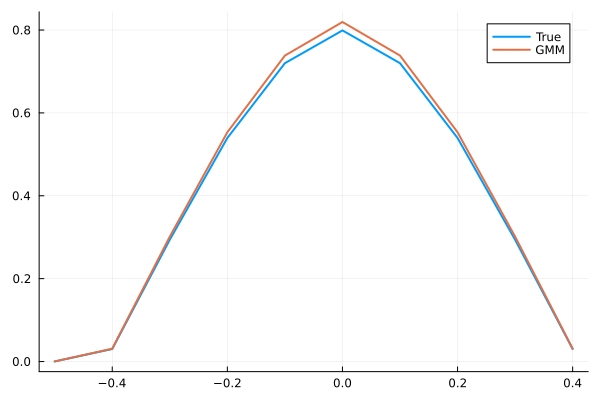

In [67]:
plot(μs, true_mu, linewidth=2, label="True")
plot!(μs, gmm_mu, linewidth=2, label="GMM")

2.5%くらいズレるがFloat32で計算しているのが原因？

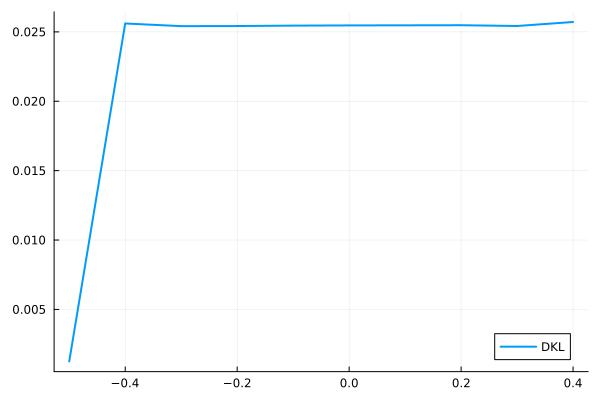

In [70]:
dels = (gmm_mu - true_mu)
plot(μs, dels./true_mu , linewidth=2, label="DKL")

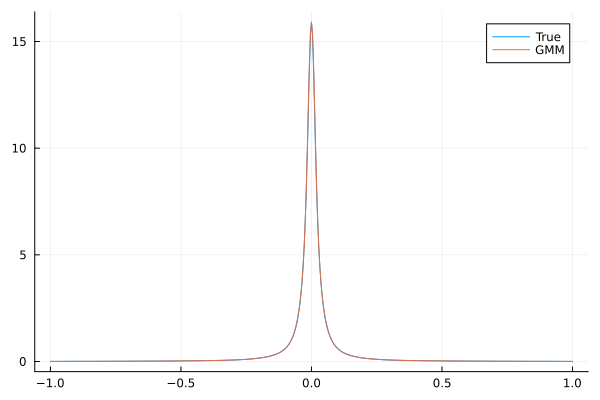

In [44]:
plot(ws, ρw, linewidth=1, label="True")
plot!(ws, ρ_gmm, linewidth=1, label="GMM")

## SparseIRの基底でデータセットを作る

In [16]:
using SparseIR

In [17]:
import SparseIR: valueim, value
import SparseIR: fit

In [18]:
struct IR_params
    beta::Float64 #inverse temperature
    bw::Float64 #Band-width

    basis::FiniteTempBasis #this is the struct defined in SparseIR. This holds the information about Fermionic/Bosonic, and the matrix which can translate the Matsubara or imaginary time to IR-basis and the inverse.
    #{Fermionic, LogisticKernel, Float64, Float64}
    
    smpl_matsu::MatsubaraSampling64F #the sampling points of Matsubara frequency
    smpl_tau::TauSampling64 #the sampling points of imaginary time

    n_matsu::Int # the number of the sampling points of Matsubara frequency
    n_tau::Int # the number of the sampling points of imaginary time

    smpl_wn::Vector{ComplexF64}#the sampling points of Matsubara frequency(type is different from smpl_matsu)
end

In [19]:
#IR_paramsをセットするための関数
function set_IR(beta::Float64, bw::Float64, del::Float64)
    #SparseIRの関数を使ってbasisを定義する。
    #FiniteTempBasis(粒子の種類, 逆温度, バンド幅, 許容する誤差(特異値分解の際に使用))
    basis = FiniteTempBasis(Fermionic(), beta, bw, del)

    #よく使うことになるので、basisから松原と虚時間のsampling pointsを取り出しておく
    smpl_matsu = MatsubaraSampling(basis)
    n_matsu = size(smpl_matsu.sampling_points)[1]

    smpl_tau = TauSampling(basis)
    n_tau = size(smpl_tau.sampling_points)[1]

    #smpl_matsuのままだとtypeがよく分からず後に不便を感じたのでVector{Complex}の型に直しておく
    smpl_wn = zeros(ComplexF64, n_matsu)
    for w in 1:n_matsu
        smpl_wn[w] = valueim(smpl_matsu.sampling_points[w], beta)
    end

    return IR_params(beta, bw, basis, smpl_matsu, smpl_tau, n_matsu, n_tau, smpl_wn)
end

set_IR (generic function with 1 method)

In [20]:
function calc_rhol(ws::Vector{Float64} ,ρ::Vector{Float64}, ir_w_basis)
    ir_ls = ir_w_basis(ws)
    dw = (ws[2] - ws[1])
    #return dw*ir_ls'*ρ
    return cross_integration_sympson(ir_ls, ρ, dw)
end

calc_rhol (generic function with 1 method)

In [21]:
function rho2gl(ws::Vector{Float64} ,ρ::Vector{Float64}, ir::IR_params)
    l = length(ir.basis.s)
    ρl = [calc_rhol(ws, ρ, ir.basis.v[i]) for i in 1:l]
    gl = -ir.basis.s .* ρl
    return gl
end

rho2gl (generic function with 1 method)

In [62]:
function rand_init_params(K::Int)
    μ = rand(Uniform(-1.0,1.0),K)
    Σ = exp.(rand(Uniform(-8.0,8.0),K))
    ϕ = softmax(rand(Uniform(-5.0,5.0),K))
    #[1.0/K for i in 1:K]
    return gParams(K, μ, Σ, ϕ)
end

function gparams2data(p::gParams)
    ord = sortperm(p.ϕ)
    return [p.μ[ord]..., log.(p.Σ[ord])..., p.ϕ[ord]...]
    #return [p.μ..., p.Σ..., p.ϕ...]
end

function gmm1(w::Float64, p::gParams)
    #μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([p.ϕ[i]*pdf(Normal(p.μ[i], p.Σ[i]), w) for i in 1:p.K])
    return y
end

function gmm_rho(ws::Vector{Float64}, p::gParams)
    return [gmm1(w, p) for w in ws]
end

function check_rhol(w_size::Int, n_gauss::Int, ir::IR_params)
    ws = [range(-ir.bw, ir.bw, length=w_size)...]
    gmm_params = rand_init_params(n_gauss)
    gmm_rho0 = gmm_rho(ws, gmm_params)
    l = length(ir.basis.s)
    ρl = [calc_rhol(ws, gmm_rho0, ir.basis.v[i]) for i in 1:l]
    ρ_recov = ρl' * ir.basis.v(ws)
    return gmm_rho0, ρl, ρ_recov
end

function create_data(w_size::Int, n_gauss::Int, ir::IR_params)
    ws = [range(-ir.bw,ir.bw, length=w_size)...]
    gmm_params = rand_init_params(n_gauss)
    gmm_rho0 = gmm_rho(ws, gmm_params)
    gl_gmm = Float32.(rho2gl(ws, gmm_rho0, ir))
    data = gparams2data(gmm_params)
    return (gl_gmm, data)
end
function create_data2(w_size::Int, n_gauss::Int, ir::IR_params)
    ws = [range(-ir.bw,ir.bw, length=w_size)...]
    gmm_params = rand_init_params(n_gauss)
    gmm_rho0 = gmm_rho(ws, gmm_params)
    gl_gmm = Float32.(rho2gl(ws, gmm_rho0, ir))
    #data = gparams2data(gmm_params)
    return gl_gmm, gmm_rho0
end

create_data2 (generic function with 1 method)

In [23]:
ir_test = set_IR(100.0, 1.0, 1e-10)

IR_params(100.0, 1.0, FiniteTempBasis{Fermionic, LogisticKernel}(LogisticKernel(100.0), SparseIR.SVEResult{LogisticKernel}(SparseIR.PiecewiseLegendrePoly[SparseIR.PiecewiseLegendrePoly(16, -1.0, 1.0, [-1.0, -0.9971969191007053, -0.9939631887430201, -0.9902327485573953, -0.9859294594055299, -0.9809655949653976, -0.9752401232983684, -0.9686367577352446, -0.9610217593708021, -0.9522414800459728  …  0.9522414800459728, 0.9610217593708021, 0.9686367577352446, 0.9752401232983684, 0.9809655949653976, 0.9859294594055299, 0.9902327485573953, 0.9939631887430201, 0.9971969191007053, 1.0], [0.0028030808992947076, 0.0032337303576851495, 0.0037304401856248504, 0.004303289151865397, 0.004963864440132304, 0.005725471667029192, 0.0066033655631237975, 0.00761499836444246, 0.008780279324829388, 0.010121832962441735  …  0.010121832962441735, 0.008780279324829388, 0.00761499836444246, 0.0066033655631237975, 0.005725471667029192, 0.004963864440132304, 0.004303289151865397, 0.0037304401856248504, 0.003233730

In [25]:
function cross_integration_sympson(f::Vector{Float64}, g::Vector{Float64}, dw::Float64)
    l = length(f)
    return dw/3*(f[1]*g[1] + 4*sum(f[2:2:end].*g[2:2:end]) + 2*sum(f[3:2:end-1].*g[3:2:end-1]) + f[end]*g[end])
end

cross_integration_sympson (generic function with 1 method)

In [26]:
function check_orth(ir::IR_params, w_size::Int, l0::Int)
    ws = [range(-ir.bw,ir.bw, length=w_size)...]
    ws = ws[2:end-1]
    dw = (ws[2] - ws[1])
    l = length(ir.basis.s)
    orth = zeros(Float64, l)
    println(l)
    for i in 1:l
        #orth[i] = dw*(ir.basis.v[i](ws))'*(ir.basis.v[l0](ws))
        orth[i] = cross_integration_sympson(ir.basis.v[i](ws), ir.basis.v[l0](ws), dw)
    end
    return orth
end

check_orth (generic function with 1 method)

In [27]:
check_orth(ir_test, 8001, 3)

30


30-element Vector{Float64}:
 -4.175197306698219e-5
  0.0
  0.9999095061276566
  7.579122514773567e-17
 -0.0001391098261032281
  3.7895612573867836e-17
 -0.00018376158040137936
 -1.8947806286933918e-17
 -0.00022629159923240926
  4.7369515717334795e-18
 -0.00026780729792014993
  2.6053233644534137e-17
 -0.0003087755659837823
  ⋮
 -0.00043007207727578726
  9.473903143466959e-18
 -0.00047011252549512806
 -4.7369515717334795e-18
 -0.0005099153118710113
 -2.3684757858667398e-18
 -0.0005494142481136588
 -4.7369515717334795e-18
 -0.0005885273050483694
  5.9211894646668494e-18
 -0.0006271626166061669
 -3.55271367880011e-18

In [ ]:
gmm_eho_test, rhol_test, rho_recov_test = check_rhol(4001, 5, ir_test)

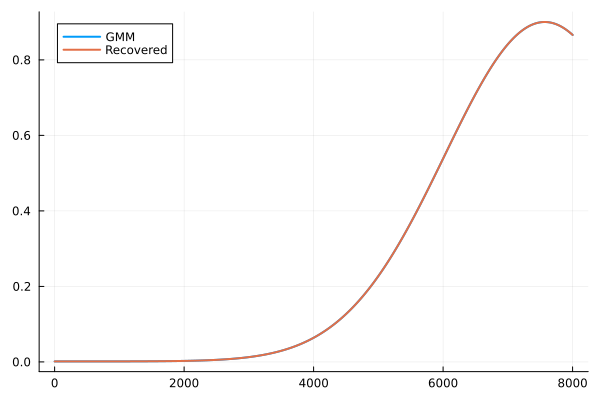

In [29]:
gmm_eho_test, rhol_test, rho_recov_test = check_rhol(8001, 5, ir_test)
plot(gmm_eho_test, linewidth=2, label="GMM")
plot!(rho_recov_test', linewidth=2, label="Recovered")

In [30]:
using BenchmarkTools

In [45]:
test_data = create_data(4001, 10, ir_test)

(Float32[1.099315, -0.3228629, -0.078096785, 0.07604788, -0.084255084, 0.023148138, 0.02396239, -0.012624437, 0.0010690311, 0.0024267142  …  1.6705712f-6, -6.273751f-6, 1.1229919f-6, 7.705704f-7, -3.3238982f-7, -4.2837407f-8, 5.2861505f-8, 1.011944f-9, -7.960313f-9, 9.517227f-10], Float32[0.18337186, -0.19598077, -0.69440156, -0.8374274, 0.60083705, -0.6953458, 0.10265446, 0.33721745, 0.10739007, 0.02391297  …  0.0005090192, 0.0032087415, 0.0046840613, 0.0053703864, 0.01921895, 0.123522654, 0.12373003, 0.1575726, 0.2303363, 0.33184725])

In [47]:
test_data[2][21:30]

10-element Vector{Float32}:
 0.0005090192
 0.0032087415
 0.0046840613
 0.0053703864
 0.01921895
 0.123522654
 0.12373003
 0.1575726
 0.2303363
 0.33184725

In [31]:
using CUDA

In [32]:
function proj_m(K::Int)
    M = zeros(Int, 3K, 3K)
    for i in 1:K
        M[2K+i, 2K+i] = 1
    end
    return M
end


proj_m (generic function with 1 method)

In [33]:
tanh5(x) = 5tanh(x)
tanh8(x) = 8tanh(x)

tanh8 (generic function with 1 method)

In [74]:
function init_model(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), (Dense(width, width, softplus) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh8), Dense(width, n_gauss, tanh5)))
end
#const proj5 = proj_m(5) |> gpu
function loss(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    mu = out[1:K,:]
    sigma = exp.(out[K+1:2K,:])
    loss = sum(phi.*((mu .- ans[1:K,:])./ ans[K+1:2K, :]).^2) + λ * sum(ans[2K+1:3K, :].*log.(ans[2K+1:3K, :] ./ (phi .+ 1f-8)))
    return loss/l
end

function loss2(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    true_phi = ans[2K+1:3K, :]
    mu = out[1:K,:]
    sigma = out[K+1:2K,:]
    loss = sum(true_phi .* ((mu .- ans[1:K,:]).^2 + (sigma .- ans[K+1:2K,:]).^2)) + λ * sum(phi.*log.(phi ./ (true_phi .+ 1f-8)))
    return loss/l
end

loss2 (generic function with 1 method)

In [82]:
model_test = init_model(30, 2, 64, 6) |> gpu

Chain(
  Dense(30 => 64),                      # 1_984 parameters
  Dense(64 => 64, softplus),            # 4_160 parameters
  Dense(64 => 64, softplus),            # 4_160 parameters
  Dense(64 => 64, softplus),            # 4_160 parameters
  Dense(64 => 64, softplus),            # 4_160 parameters
  Dense(64 => 64, softplus),            # 4_160 parameters
  Dense(64 => 64, softplus),            # 4_160 parameters
  Parallel(
    vcat,
    Dense(64 => 2, tanh),               # 130 parameters
    Dense(64 => 2, tanh8),              # 130 parameters
    Dense(64 => 2, tanh5),              # 130 parameters
  ),
)                   # Total: 20 arrays, 27_334 parameters, 3.320 KiB.

In [36]:
function create_data(w_size::Int, n_gauss::Int, ir::IR_params)
    ws = [range(-ir.bw,ir.bw, length=w_size)...]
    gmm_params = rand_init_params(n_gauss)
    gmm_rho0 = gmm_rho(ws, gmm_params)
    gl_gmm = Float32.(rho2gl(ws, gmm_rho0, ir))
    data = gparams2data(gmm_params)
    return gl_gmm, data
end

create_data (generic function with 1 method)

In [37]:
function dataset(n::Int, w_size::Int, n_gauss::Int, ir::IR_params)
    inputs = zeros(Float32, ir.n_matsu, n)
    outputs = zeros(Float32, 3n_gauss, n)
    for i in 1:n
        inputs[:,i], outputs[:,i] = create_data(w_size, n_gauss, ir)
    end
    return inputs, outputs
end

dataset (generic function with 1 method)

In [83]:
K=2
for it in 1:20
    if(it < 6)
        opt = Flux.Optimiser(WeightDecay(1f-5), Adam(1f-4))
        opt_state = Flux.setup(opt, model_test) 
    elseif(it < 13)
        opt = Flux.Optimiser(WeightDecay(1f-5), Adam(5f-5))
        opt_state = Flux.setup(opt, model_test)
    else
        opt = Flux.Optimiser(WeightDecay(1f-5), Adam(2f-5))
        opt_state = Flux.setup(opt, model_test) 
    end
    dt = Flux.DataLoader(dataset(4096, 4001, K, ir_test), batchsize=256, shuffle=true)
    for epoch in 1:500
        Flux.train!(model_test, dt, opt_state) do m,x,y
            loss2(m, K, x, y, 1.0f0)
        end
    end
    test = first(dt)
    println("it: $(it), loss: $(loss2(model_test, K, test[1], test[2], 1.0f0))")
end

it: 1, loss: 4.9113774
it: 2, loss: 5.239879
it: 3, loss: 4.5897803
it: 4, loss: 4.692939
it: 5, loss: 4.031468
it: 6, loss: 4.2033687
it: 7, loss: 3.5446043
it: 8, loss: 3.235113
it: 9, loss: 3.7441454
it: 10, loss: 2.855391
it: 11, loss: 2.5187397
it: 12, loss: 2.768011
it: 13, loss: 2.97394
it: 14, loss: 3.1058855
it: 15, loss: 2.3269017
it: 16, loss: 2.7454836
it: 17, loss: 2.7594824
it: 18, loss: 2.8750687
it: 19, loss: 2.377374
it: 20, loss: 2.6099052


In [44]:
another_data = dataset(128, 4001, 5, ir_test)
loss(model_test, 5, another_data[1], another_data[2], 0.1f0)

388.2432f0

In [53]:
function gmm1(K::Int, w::Float32, μ::Vector{Float32}, Σ::Vector{Float32}, ϕ::Vector{Float32})
    #μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([ϕ[i]*pdf(Normal(μ[i], Σ[i]), w) for i in 1:K])
    return y
end

function data2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = out[2K+1:3K]
    mu = out[1:K]
    sigma = out[K+1:2K]
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end

function out2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = softmax(out[2K+1:3K])
    mu = out[1:K]
    sigma = exp.(out[K+1:2K])
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end

out2dist (generic function with 1 method)

Float32[0.48260197, 0.89704776]
Float32[-2.0704226, 6.624473]
Float32[0.49096847, 0.50903153]
Float32[0.39479896, 0.07217753]
Float32[1.2265722, 1.8204764]
Float32[-4.9991484, -4.2343383]


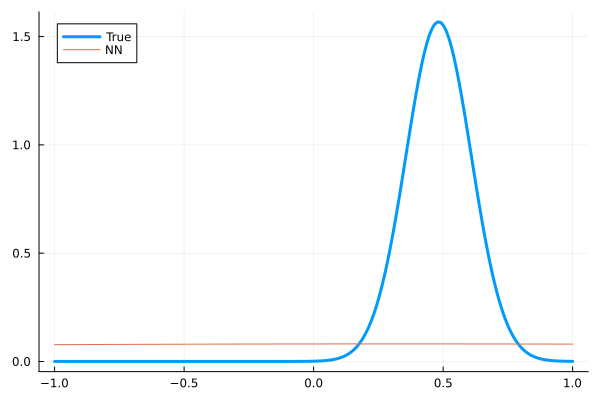

In [85]:

test_gl, gmm_test = create_data(4001, K, ir_test)
println(gmm_test[1:K])
println(gmm_test[K+1:2K])
println(gmm_test[2K+1:3K])
test_out = cpu(model_test(cu(test_gl)))
println(test_out[1:K])
println(test_out[K+1:2K])
println(test_out[2K+1:3K])
rho_true = out2dist(gmm_test, K, 1001)
rho_NN = out2dist(test_out, K, 1001)
ws_test = [range(-1.0f0,1.0f0, length=1001)...]
plot(ws_test, rho_true, linewidth=3, label="True")
plot!(ws_test, rho_NN, linewidth=1, label="NN")